In [22]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
import warnings
warnings.filterwarnings('ignore')

In [2]:
training_directory = 'Dataset directory/train/'
testing_directory = 'Dataset directory/test/'

In [3]:
row=48
col=48
classes = 7

In [4]:
#Counting Number of Images in an expression folder
def count(path,set_):
    dic={}
    for exp in os.listdir(path):
        dir_ = path + exp
        dic[exp]=len(os.listdir(dir_))

    df = pd.DataFrame(dic,index=[set_])
    return df
train_count=count(training_directory,'training_count')
print(train_count)
test_count=count(testing_directory,'testing_count')
print(test_count)

                angry  disgust  fear  happy  neutral   sad  surprise
training_count   3995      436  4097   7215     4965  4830      3171
               angry  disgust  fear  happy  neutral   sad  surprise
testing_count    958      111  1024   1774     1233  1247       831


Text(0.5, 1.0, 'Plot of number of images in train dataset')

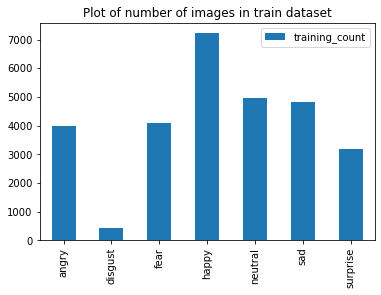

In [5]:
train_count.transpose().plot(kind = "bar")
plt.title('Plot of number of images in train dataset')

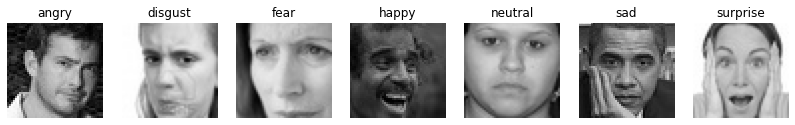

In [10]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(training_directory):
    img = tf.keras.preprocessing.image.load_img((training_directory + expression +'/'+ os.listdir(training_directory + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [11]:
#Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,Dense, MaxPooling2D,Flatten,Dropout,Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger,TensorBoard,EarlyStopping,ReduceLROnPlateau
import datetime
from tensorflow.keras.utils import plot_model

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    zoom_range=0.3, 
                                    horizontal_flip=True)

train_set=train_datagen.flow_from_directory(training_directory,
                                            batch_size=64,
                                            target_size=(48,48),
                                            shuffle=True,
                                            color_mode="grayscale",class_mode='categorical')



test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(testing_directory,
                                            batch_size=64,
                                            target_size=(48,48),
                                            shuffle=True,
                                            color_mode="grayscale",class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [13]:
train_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [14]:
#Model Building

In [15]:
#initalising the CNN model

def get_model(input_size, classes=7):
     #BUILDING the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #COMPLILING the CNN
    model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [16]:
our_model = get_model((row,col,1),classes)
our_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 256)       2

In [17]:
steps_per_epoch = train_set.n // train_set.batch_size
validation_steps = test_set.n // test_set.batch_size

mod = our_model.fit(x=train_set,
                 validation_data=test_set,
                 epochs=2,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/2
448/448 [==============================] - 289s 644ms/step - loss: 4.3005 - accuracy: 0.2794 - val_loss: 8.2179 - val_accuracy: 0.1370
Epoch 2/2
448/448 [==============================] - 265s 591ms/step - loss: 3.4990 - accuracy: 0.3420 - val_loss: 3.1467 - val_accuracy: 0.3984


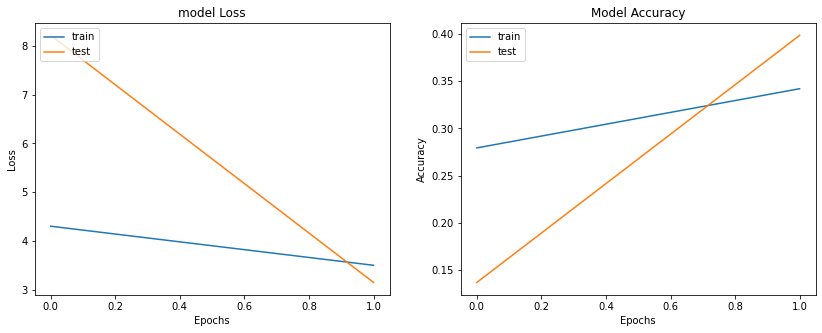

In [18]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(mod.history['accuracy'])
plt.plot(mod.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(mod.history['loss'])
plt.plot(mod.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
train_loss, train_accu = our_model.evaluate(train_set)
test_loss, test_accu = our_model.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 26s 228ms/step - loss: 3.1473 - accuracy: 0.3982
final train accuracy = 38.29 , validation accuracy = 39.82


Confusion Matrix
[[ 155    0  128 1585 1215  197  715]
 [  18    0   19  164  129   27   79]
 [ 163    0  139 1627 1245  201  722]
 [ 237    0  237 2898 2197  400 1246]
 [ 164    0  179 2012 1465  286  859]
 [ 190    0  184 1909 1428  262  857]
 [ 134    0  112 1290  958  172  505]]
Classification Report
              precision    recall  f1-score   support

       angry       0.15      0.04      0.06      3995
     disgust       0.00      0.00      0.00       436
        fear       0.14      0.03      0.05      4097
       happy       0.25      0.40      0.31      7215
     neutral       0.17      0.30      0.22      4965
         sad       0.17      0.05      0.08      4830
    surprise       0.10      0.16      0.12      3171

    accuracy                           0.19     28709
   macro avg       0.14      0.14      0.12     28709
weighted avg       0.17      0.19      0.16     28709



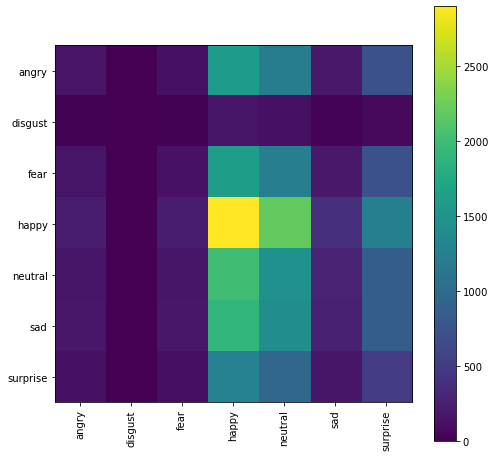

In [23]:
#ON TRAINING SET
y_pred = our_model.predict(train_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(train_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion Matrix
[[ 40   0  30 398 234  42 214]
 [  7   0   7  40  29   3  25]
 [ 39   0  44 446 234  45 216]
 [ 60   0  66 736 411  79 422]
 [ 46   0  47 502 316  54 268]
 [ 58   0  43 540 289  47 270]
 [ 40   0  32 333 210  30 186]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.04      0.06       958
     disgust       0.00      0.00      0.00       111
        fear       0.16      0.04      0.07      1024
       happy       0.25      0.41      0.31      1774
     neutral       0.18      0.26      0.21      1233
         sad       0.16      0.04      0.06      1247
    surprise       0.12      0.22      0.15       831

    accuracy                           0.19      7178
   macro avg       0.14      0.15      0.12      7178
weighted avg       0.17      0.19      0.16      7178



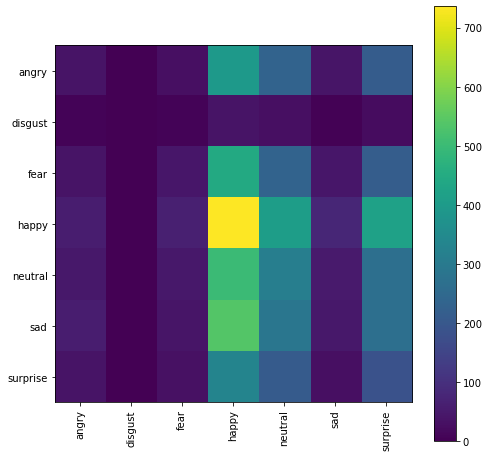

In [24]:
#ON TESTING SET
y_pred = our_model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)